In [1]:
from typing import List, Optional
from torch.optim.optimizer import Optimizer

import os
import hydra
from torch import nn
from omegaconf import DictConfig
import pytorch_lightning as pl
from pytorch_lightning import (
    Callback,
    LightningDataModule,
    LightningModule,
    Trainer,
    seed_everything,
)
from pytorch_lightning.loggers import LightningLoggerBase

from torch.utils.data import Dataset
from src.utils import utils
from hydra import compose, initialize
from omegaconf import OmegaConf
from src.metrics.bounding_box import BoundingBox
from src.metrics.enumerators import BBType, CoordinatesType, BBFormat, MethodAveragePrecision
from enum import Enum

# GlobalHydra.instance().clear()
initialize(config_path="../configs/", job_name="test_app")

hydra.initialize()

In [2]:
config = compose(config_name="experiments/pest-detection-ssd/base.yaml", overrides=[])

In [3]:
datamodule: LightningDataModule = hydra.utils.instantiate(config.datamodule, data_config = config.datamodule, _recursive_=False)
datamodule.setup()

In [4]:
from src.data.utils import generate_dboxes, Encoder

dboxes = generate_dboxes(model="ssd")
box_encoder = Encoder(dboxes = dboxes)
criterion = hydra.utils.instantiate(config.model.loss, dboxes = dboxes)
network = hydra.utils.instantiate(config.model.network)

### Trial Run (Check if this works)

In [6]:
pd_boxes_trial = [BoundingBox(image_name = 'a',
                 class_id=str(1.),
                 coordinates=(0.25, 0.25, 0.75, 0.75),
                 type_coordinates=CoordinatesType.RELATIVE,
                 img_size=(300, 300),
                 bb_type=BBType.DETECTED,
                 confidence=0.99,
                 format=BBFormat.XYX2Y2)]
gt_boxes_trial = [BoundingBox(image_name = 'a',
                 class_id=str(1.),
                 coordinates=(0.25, 0.25, 0.85, 0.75),
                 type_coordinates=CoordinatesType.RELATIVE,
                 img_size=(300, 300),
                 bb_type=BBType.GROUND_TRUTH,
                 format=BBFormat.XYX2Y2)]

In [7]:
from src.metrics.pascal_voc_evaluator import get_pascalvoc_metrics, get_metrics

In [8]:
d_ = get_pascalvoc_metrics(gt_boxes_trial,
                          pd_boxes_trial,
                          iou_threshold=0.1,
                          method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
                          generate_table=False)

In [9]:
d_

{'per_class': {'1.0': {'precision': array([1.]),
   'recall': array([1.]),
   'AP': 1.0,
   'interpolated precision': [1.0, 1.0],
   'interpolated recall': [0, 1.0],
   'total positives': 1,
   'total TP': 1.0,
   'total FP': 0.0,
   'method': <MethodAveragePrecision.EVERY_POINT_INTERPOLATION: 1>,
   'iou': 0.1,
   'table': None}},
 'mAP': 1.0}

### Test on Our dataset

In [10]:
for batch_id, batch in enumerate(datamodule.train_dataloader()):
    break

In [11]:
images, glocs, glabels, img_ids = batch['imgs'], batch['bbox_coords'], batch['bbox_classes'], batch['img_ids']
plocs, plabels = network(images)

In [147]:
# Create List[BoundingBox] format for pascal_voc_evaluator
pd_boxes = []
gt_boxes = []

# Loop through batch
for idx in range(plocs.shape[0]):
    ploc_i = plocs[idx, :, :].unsqueeze(0)
    plabel_i = plabels[idx, :, :].unsqueeze(0)
    try:
        result = box_encoder.decode_batch(ploc_i, plabel_i, 0.5, 200)[0]
    except:
        print("No object detected in idx: {}".format(idx))
        continue

    loc, label, prob = [r.detach().numpy() for r in result]
    for loc_, label_, prob_ in zip(loc, label, prob):
        pd_boxes.append(BoundingBox(image_name = img_ids[idx],
                class_id=str(label_),
                coordinates=(loc_[0], loc_[1], loc_[2], loc_[3]),
                type_coordinates=CoordinatesType.RELATIVE,
                img_size=(300, 300),
                bb_type=BBType.DETECTED,
                confidence=prob_,
                format=BBFormat.XYX2Y2))

    gloc_i = glocs[idx]
    glabel_i = glabels[idx]

    if glabel_i.numel() == 0:
        continue

    gloc_i, glabel_i = gloc_i.detach().numpy(), glabel_i.detach().numpy()
    for loc_, label_ in zip(gloc_i, glabel_i):
        gt_boxes.append(BoundingBox(image_name = img_ids[idx],
                class_id=str(label_),
                coordinates=(loc_[0], loc_[1], loc_[2], loc_[3]),
                type_coordinates=CoordinatesType.RELATIVE,
                img_size=(300, 300),
                bb_type=BBType.GROUND_TRUTH,
                format=BBFormat.XYX2Y2)) 

In [22]:
# [(b._x, b._y, b._w, b._h, b._x2, b._y2, b._class_id) for b in gt_boxes]

In [12]:
d = get_metrics(img_ids = img_ids,
                ploc = ploc, plabel = plabel, gloc = gloc, glabel = glabel,
                img_shape = (300, 300),
                nms_threshold = 0.5,
                max_num = 200,
                iou_threshold = 0.5,
                encoder = box_encoder)

In [12]:
i = 8
img_id, image, ground_truth_box, ploc, plabel = img_ids[i], images[i], glocs[i], plocs[i], plabels[i]

In [13]:
image.shape, ground_truth_box.shape, ploc.shape, plabel.shape

(torch.Size([3, 300, 300]),
 torch.Size([3, 4]),
 torch.Size([4, 8732]),
 torch.Size([2, 8732]))

In [14]:
from PIL import Image
import  numpy as np
import matplotlib.pyplot as plt

In [15]:
im = np.transpose(image.numpy(), (1, 2, 0))

In [16]:
bbox = ground_truth_box.numpy()
bbox = (bbox * 300).astype(np.int32).tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


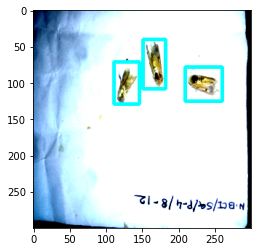

In [21]:
plt.imshow(draw_multiple_rectangles(im, bbox))

In [142]:
result = box_encoder.decode_batch(ploc.unsqueeze(0), plabel.unsqueeze(0), 0.3, 200)[0]

In [143]:
result[0].shape

torch.Size([100, 4])

In [144]:
pred_bbox = result[0].detach().numpy()
pred_bbox = (pred_bbox * 300).astype(np.int32).tolist()

In [20]:
import cv2
def draw_rectangle(img,
                   bbox,
                   bbox_color=(0, 255, 255),
                   thickness=3,
                   is_opaque=False,
                   alpha=0.5):
    """Draws the rectangle around the object
    Parameters
    ----------
    img : ndarray
        the actual image
    bbox : list
        a list containing x_min, y_min, x_max and y_max of the rectangle positions
    bbox_color : tuple, optional
        the color of the box, by default (255,255,255)
    thickness : int, optional
        thickness of the outline of the box, by default 3
    is_opaque : bool, optional
        if False, draws a solid rectangular outline. Else, a filled rectangle which is semi transparent, by default False
    alpha : float, optional
        strength of the opacity, by default 0.5
    Returns
    -------
    ndarray
        the image with the bounding box drawn
    """

    output = img.copy()
    if not is_opaque:
        cv2.rectangle(output, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                      bbox_color, thickness)
    else:
        overlay = img.copy()

        cv2.rectangle(overlay, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                      bbox_color, -1)
        cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    return output

def draw_multiple_rectangles(img,
                             bboxes,
                             bbox_color=(0, 255, 255),
                             thickness=3,
                             is_opaque=False,
                             alpha=0.5):
    """draws multiple rectangles
    img : ndarray
        the actual image
    bboxes : list
        a list of lists, each inner list containing x_min, y_min, x_max and y_max of the rectangle positions
    bbox_color : tuple, optional
        the color of the boxes, by default (255,255,255)
    thickness : int, optional
        thickness of the outline of the boxes, by default 3
    is_opaque : bool, optional
        if False, draws solid rectangular outlines for rectangles. Else, filled rectangles which are semi transparent, by default False
    alpha : float, optional
        strength of the opacity, by default 0.5
    Returns
    -------
    ndarray
        the image with the bounding boxes drawn
    """

    for bbox in bboxes:
        img = draw_rectangle(img, bbox, bbox_color, thickness, is_opaque,
                             alpha)
    return img


### Define Network

In [3]:
model: LightningModule = hydra.utils.instantiate(config.model,  model_config = config.model, _recursive_=False)

/root/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [7]:
# net(batch[0])